# Pareto-based neural network ensemble 

In [1]:
import h5py
import numpy as np
import os

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf

from deap import algorithms
from deap import base
from deap import benchmarks
from deap.benchmarks.tools import diversity, convergence, hypervolume
from deap import creator
from deap import tools

import array
import random
import json
import math

from scipy import stats

2024-11-21 14:47:26.552624: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-21 14:47:26.555854: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-21 14:47:26.568145: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-21 14:47:26.584773: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-21 14:47:26.589291: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 14:47:26.601448: I tensorflow/core/platform/cpu_feature_gu

## The data

CIFAR 10

In [2]:
(train_images, train_labels_ix), (test_images, test_labels_ix) = tf.keras.datasets.cifar10.load_data()

In [3]:
# Checking the number of rows (records) and columns (features)
print(train_images.shape)
print(train_labels_ix.shape)
print(test_images.shape)
print(test_labels_ix.shape)


(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


(array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

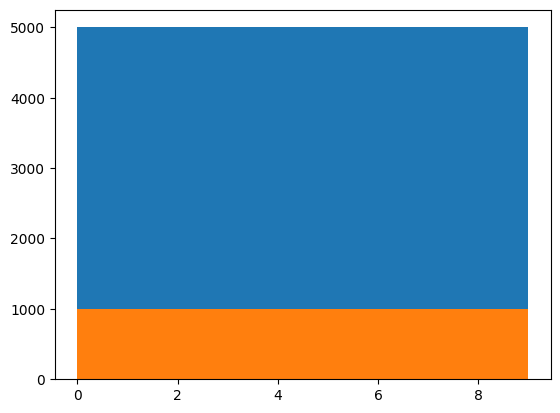

In [4]:
plt.hist(train_labels_ix)
plt.hist(test_labels_ix)

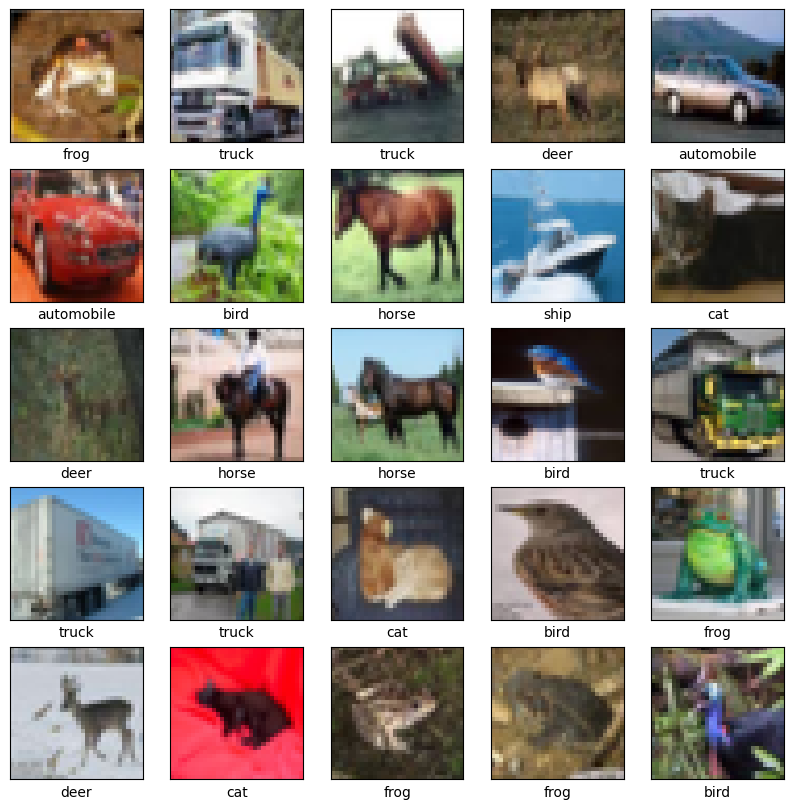

In [5]:
# Creating a list of all the class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Visualizing some of the images from the training dataset
plt.figure(figsize=[10,10])
for i in range (25):    # for first 25 images
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.binary)
  plt.xlabel(class_names[train_labels_ix[i][0]])

plt.show()



In [167]:
def load_new_test_data(version_string=''):
    data_path = 'localdata/'
    filename = 'cifar10.1'
    if version_string == '':
        version_string = 'v7'
    if version_string in ['v4', 'v6', 'v7']:
        filename += '_' + version_string
    else:
        raise ValueError('Unknown dataset version "{}".'.format(version_string))
    label_filename = filename + '_labels.npy'
    imagedata_filename = filename + '_data.npy'
    label_filepath = os.path.abspath(os.path.join(data_path, label_filename))
    imagedata_filepath = os.path.abspath(os.path.join(data_path, imagedata_filename))
    labels = np.load(label_filepath)
    imagedata = np.load(imagedata_filepath)
    assert len(labels.shape) == 1
    assert len(imagedata.shape) == 4
    assert labels.shape[0] == imagedata.shape[0]
    assert imagedata.shape[1] == 32
    assert imagedata.shape[2] == 32
    assert imagedata.shape[3] == 3
    if version_string == 'v6' or version_string == 'v7':
        assert labels.shape[0] == 2000
    elif version_string == 'v4':
        assert labels.shape[0] == 2021

    labels = np.reshape(labels, (labels.shape[0], 1))

    return imagedata, labels
        
images_v4, labels_v4_ix = load_new_test_data('v4')

print(images_v4.shape, labels_v4_ix.shape)

(2021, 32, 32, 3) (2021, 1)


(array([208., 212., 202., 212., 204., 218., 192., 210., 161., 202.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

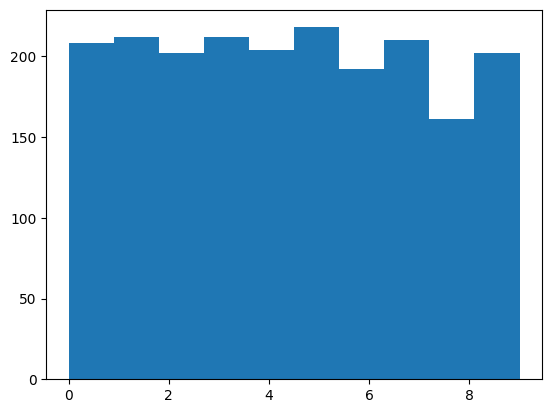

In [168]:
plt.hist(labels_v4_ix)

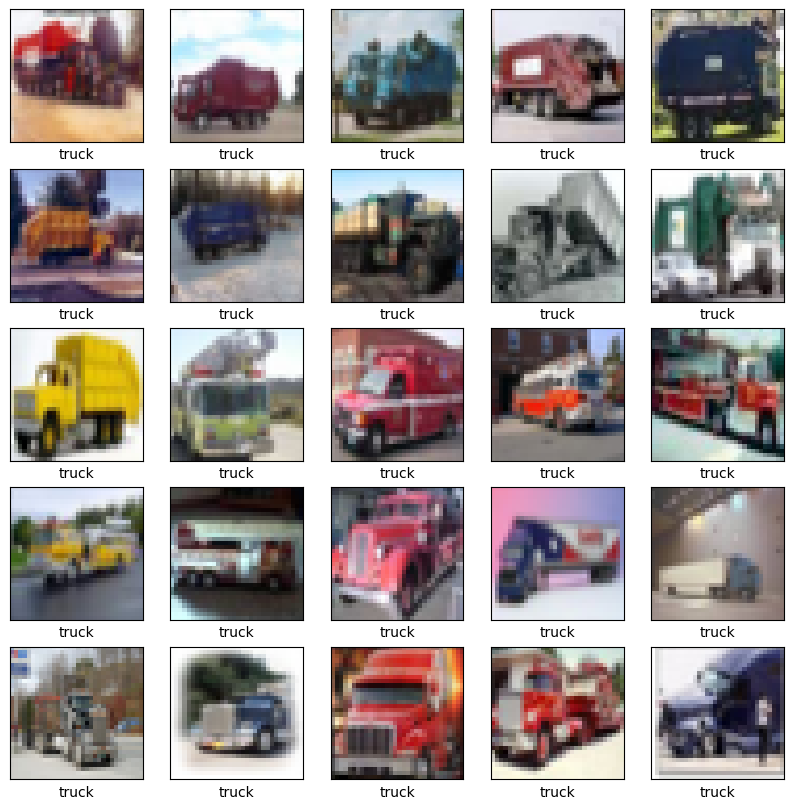

In [172]:
# Visualizing some of the images from the training dataset
plt.figure(figsize=[10,10])
for i in range(25):    # for first 25 images
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(images_v4[300+i], cmap=plt.cm.binary)
  plt.xlabel(class_names[labels_v4_ix[300+i][0]])

plt.show()

## Artificial neural network

In [173]:
# Converting the pixels data to float type
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
 
# Standardizing (255 is the total number of pixels an image can have)
train_images = train_images / 255
test_images = test_images / 255 

# One hot encoding the target class (labels)
num_classes = 10
train_labels = tf.keras.utils.to_categorical(train_labels_ix, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels_ix, num_classes)

images_v4 = images_v4.astype('float32')
images_v4 = images_v4 / 255
labels_v4 = tf.keras.utils.to_categorical(labels_v4_ix, num_classes)

In [10]:
def fcn_model(num_classes=10, dropout_rate=0.2):        
    input = tf.keras.layers.Input(shape=(32, 32, 3))

    # A convolution block
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(input)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # Fully connected layer 1
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=1, strides=1)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # Fully connected layer 2
    x = tf.keras.layers.Conv2D(filters=num_classes, kernel_size=1, strides=1)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)    

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)   
    
    model = tf.keras.Model(inputs=input, outputs=predictions)
    
    return model   

init_model = fcn_model()
print(init_model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 10)     │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 10)     │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10240)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,310,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,316,732 (5.02 MB)

 Trainable params: 1,316,264 (5.02 MB)

 Non-trainable params: 468 (1.83 KB)

None


In [11]:
init_model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.categorical_crossentropy, 
    metrics=['accuracy'])

In [12]:
history = init_model.fit(train_images, train_labels, epochs=10, validation_split=0.2)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 78s 60ms/step - accuracy: 0.3813 - loss: 1.8225 - val_accuracy: 0.4645 - val_loss: 1.5958
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 75s 60ms/step - accuracy: 0.5650 - loss: 1.2257 - val_accuracy: 0.5497 - val_loss: 1.3556
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 75s 60ms/step - accuracy: 0.6326 - loss: 1.0344 - val_accuracy: 0.5043 - val_loss: 1.6057
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 76s 61ms/step - accuracy: 0.6794 - loss: 0.9089 - val_accuracy: 0.5563 - val_loss: 1.7093
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 72s 57ms/step - accuracy: 0.7103 - loss: 0.8108 - val_accuracy: 0.6231 - val_loss: 1.1447
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 71s 56ms/step - accuracy: 0.7364 - loss: 0.7439 - val_accuracy: 0.6333 - val_loss: 1.1309
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 70s 56ms/step - accuracy: 0.7665 - loss: 0.6680 - val_accuracy: 0.6058 - val_loss: 1.3369
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 71s 57ms/step - accuracy: 0.7828 -

Text(0.5, 1.0, 'Loss Curves')

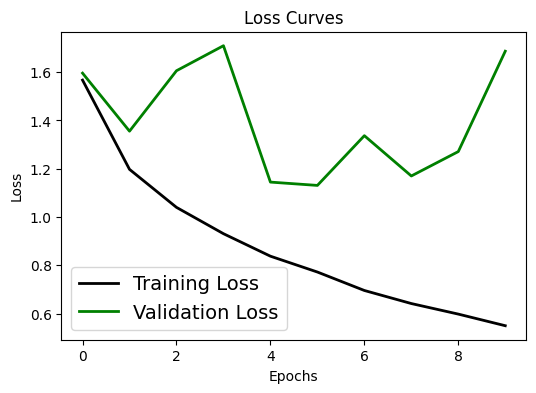

In [13]:
# Loss curve
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

Text(0.5, 1.0, 'Accuracy Curves')

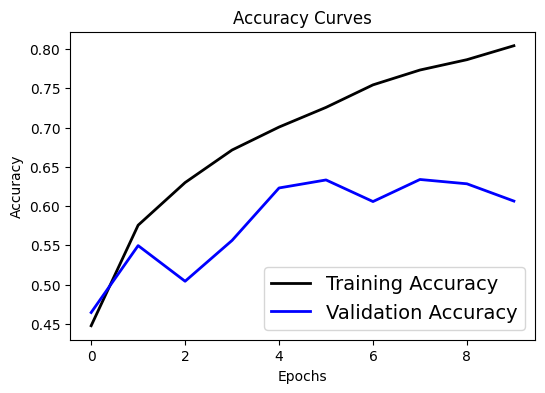

In [14]:
# Accuracy curve
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

In [15]:
# Making the Predictions
init_pred = init_model.predict(test_images)

# Converting the predictions into label index 
init_pred_classes = np.argmax(init_pred, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


In [16]:
init_acc = metrics.accuracy_score(test_labels_ix, init_pred_classes)
init_iou = metrics.jaccard_score(test_labels_ix, init_pred_classes, average="weighted")
init_f1 = metrics.f1_score(test_labels_ix, init_pred_classes, average="weighted")

print("Accuracy: %5.4f" % init_acc)
print("IoU: %5.4f" % init_iou)
print("F1 Score: %5.4f" % init_f1)


Accuracy: 0.5965
IoU: 0.4298
F1 Score: 0.5830


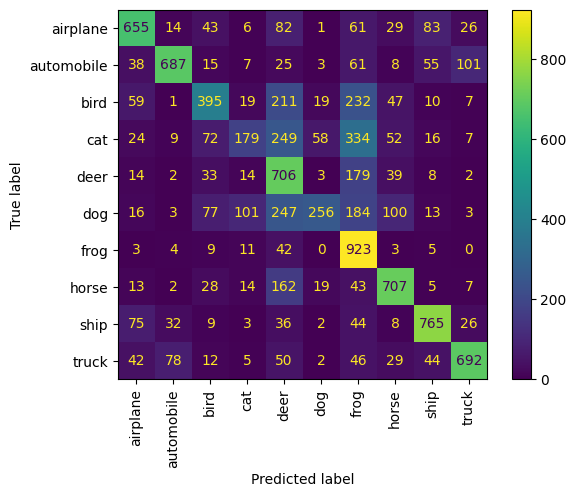

In [17]:
cm_fcn = metrics.confusion_matrix(test_labels_ix, init_pred_classes)
metrics.ConfusionMatrixDisplay(confusion_matrix=cm_fcn, 
                               display_labels=class_names).plot(xticks_rotation="vertical")

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Accuracy: 0.4641
IoU: 0.3000
F1 Score: 0.4499


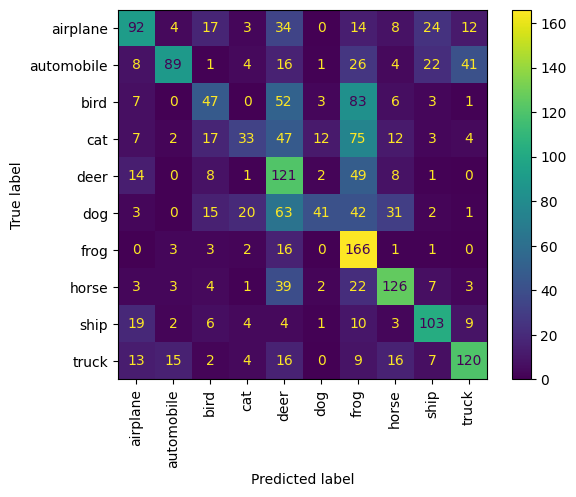

In [174]:
# Making the Predictions
init_pred_v4 = init_model.predict(images_v4)

# Converting the predictions into label index 
init_pred_classes_v4 = np.argmax(init_pred_v4, axis=1)

init_acc_v4 = metrics.accuracy_score(labels_v4_ix, init_pred_classes_v4)
init_iou_v4 = metrics.jaccard_score(labels_v4_ix, init_pred_classes_v4, average="weighted")
init_f1_v4 = metrics.f1_score(labels_v4_ix, init_pred_classes_v4, average="weighted")

print("Accuracy: %5.4f" % init_acc_v4)
print("IoU: %5.4f" % init_iou_v4)
print("F1 Score: %5.4f" % init_f1_v4)

cm_fcn_v4 = metrics.confusion_matrix(labels_v4_ix, init_pred_classes_v4)
metrics.ConfusionMatrixDisplay(confusion_matrix=cm_fcn_v4, 
                               display_labels=class_names).plot(xticks_rotation="vertical")

## NSGA-II optimization

In [19]:
pos = np.random.choice(len(train_images), size=100)

val_images = train_images[pos,:,:,:]
val_labels = train_labels_ix[pos,:]



In [20]:
class Model():    
    def __init__(self, seed_model):
        # TODO make a copy
        self.tf_model = tf.keras.models.clone_model(seed_model)
        self.tf_model.set_weights(seed_model.get_weights())

creator.create("FitnessMax", base.Fitness, weights=((1.0, ) * (num_classes+1) ))
creator.create("Individual", Model, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

def mutate_weights(model, delta=1e-4):
    # TODO improve implementation
    weights = model.get_weights()
    for w in weights:
        w += np.random.normal(loc=0.0, scale=delta, size=w.shape)         
    model.set_weights(weights)

def rand_init(seed_model):
    # seed model is a tf keras model
    model = tf.keras.models.clone_model(seed_model)
    model.compile(optimizer='adam', 
                  loss=tf.keras.losses.categorical_crossentropy, 
                  metrics=['accuracy'])
    model.set_weights(seed_model.get_weights())    
    mutate_weights(model)
    return model

toolbox.register("rand_init", rand_init, init_model)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.rand_init)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def eval_per_class(test_images, test_labels, individual):
    print(individual.tf_model.get_weights()[1][0])
    pred = individual.tf_model.predict(test_images)
    # Converting the predictions into label index 
    pred_classes = np.argmax(pred, axis=1)
    f1_per_class = metrics.f1_score(test_labels, pred_classes, average=None)
    f1 = metrics.f1_score(test_labels, pred_classes, average='weighted')
    return np.append(f1_per_class, f1)

toolbox.register("evaluate", eval_per_class, val_images, val_labels)

def w_mutation(individual):    
    mutate_weights(individual.tf_model)
    return individual

toolbox.register("mutate", w_mutation)
toolbox.register("select", tools.selNSGA2)

In [21]:
def opt_ensemble(seed=None, pop_size=4, generations=2):
    random.seed(seed)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)
    stats.register("std", np.std, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"

    pop = toolbox.population(n=pop_size)
    
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # This is just to assign the crowding distance to the individuals
    # no actual selection is done
    pop = toolbox.select(pop, len(pop))

    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(invalid_ind), **record)
    print(logbook.stream)

    # Begin the generational process
    for gen in range(1, generations):
        # dominance selection. If there is no interdominance, then crowding distance
        offspring = tools.selTournamentDCD(pop, len(pop))
        # TODO Check if this is working correctly (i.e., if the weights are copied)
        offspring = [toolbox.clone(ind) for ind in offspring]

        for ind in offspring:
            toolbox.mutate(ind)            
            del ind.fitness.values
        
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Select the next generation population
        pop = toolbox.select(pop + offspring, pop_size)
        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(invalid_ind), **record)
        print(logbook.stream)

    print("Final population hypervolume is %f" % hypervolume(pop, [1.0] * (num_classes+1)))

    return pop, logbook

In [22]:
pop, pop_stats = opt_ensemble(seed=31081984, pop_size=8, generations=10)

0.08528551
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0.085163146
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/stepWARNING:tensorflow:5 out of the last 73 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x79728178ed40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0.08538431
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0.08553247
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
0.08524538
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms

In [175]:
acc = []
iou = []
f1 = []
ind_pred_classes = None
ind_pred = list()
acc_v4 = []
iou_v4 = []
f1_v4 = []
ind_pred_classes_v4 = None
ind_pred_v4 = list()

for ind in pop:
    pred = ind.tf_model.predict(test_images)    
    pred_v4 = ind.tf_model.predict(images_v4)
    ind_pred.append(pred)
    ind_pred_v4.append(pred_v4)

    pred_classes = np.argmax(pred, axis=1)
    pred_classes_v4 = np.argmax(pred_v4, axis=1)

    if ind_pred_classes is None:
        ind_pred_classes = pred_classes
    else:
        ind_pred_classes = np.vstack([ind_pred_classes, pred_classes])

    if ind_pred_classes_v4 is None:
        ind_pred_classes_v4 = pred_classes_v4
    else:
        ind_pred_classes_v4 = np.vstack([ind_pred_classes_v4, pred_classes_v4])
        
    acc.append(metrics.accuracy_score(test_labels_ix, pred_classes))
    iou.append(metrics.jaccard_score(test_labels_ix, pred_classes, average="weighted"))
    f1.append(metrics.f1_score(test_labels_ix, pred_classes, average="weighted"))

    acc_v4.append(metrics.accuracy_score(labels_v4_ix, pred_classes_v4))
    iou_v4.append(metrics.jaccard_score(labels_v4_ix, pred_classes_v4, average="weighted"))
    f1_v4.append(metrics.f1_score(labels_v4_ix, pred_classes_v4, average="weighted"))
    

def compute_stats(metric):
    stats = dict()
    stats['mean'] = np.mean(metric)
    stats['std'] = np.std(metric)
    stats['min'] = np.min(metric)
    stats['max'] = np.max(metric)
    return stats

stats_acc = compute_stats(acc)
stats_iou = compute_stats(iou)
stats_f1 = compute_stats(f1)

stats_acc_v4 = compute_stats(acc_v4)
stats_iou_v4 = compute_stats(iou_v4)
stats_f1_v4 = compute_stats(f1_v4)




313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [178]:
# Ensemble performance metrics

# variance
tmp = np.stack(ind_pred, axis=1)
var_samp_class = np.var(tmp, axis=1)
var_samp = np.sum(var_samp_class, axis=1)
var_ens = np.mean(var_samp)

tmp = np.stack(ind_pred_v4, axis=1)
var_samp_class = np.var(tmp, axis=1)
var_samp = np.sum(var_samp_class, axis=1)
var_ens_shifted = np.mean(var_samp)

# entropy
l_z = None
for i in range(ind_pred_classes.shape[0]):
    if l_z is None:
        l_z = (ind_pred_classes[i,:] == test_labels_ix[:,0]) * 1
    else:
        l_z = l_z + (ind_pred_classes[i,:] == test_labels_ix[:,0]) * 1

entropy_ens = np.mean(np.minimum(l_z, ind_pred_classes.shape[0] - l_z) / (ind_pred_classes.shape[0] - np.ceil(ind_pred_classes.shape[0]/2)))

l_z = None
for i in range(ind_pred_classes_v4.shape[0]):
    if l_z is None:
        l_z = (ind_pred_classes_v4[i,:] == labels_v4_ix[:,0]) * 1
    else:
        l_z = l_z + (ind_pred_classes_v4[i,:] == labels_v4_ix[:,0]) * 1

entropy_ens_shifted = np.mean(np.minimum(l_z, ind_pred_classes_v4.shape[0] - l_z) / (ind_pred_classes_v4.shape[0] - np.ceil(ind_pred_classes_v4.shape[0]/2)))

In [99]:
print(stats_acc)
print(stats_iou)
print(stats_f1)

print(stats_acc_v4)
print(stats_iou_v4)
print(stats_f1_v4)



{'mean': 0.594575, 'std': 0.0010034316120194856, 'min': 0.5921, 'max': 0.5955}
{'mean': 0.42828049031690396, 'std': 0.0009531729141235287, 'min': 0.42609838385348475, 'max': 0.4292859196700618}
{'mean': 0.581474033377128, 'std': 0.0010007169861791978, 'min': 0.5791665499287646, 'max': 0.5824926755010991}
{'mean': 0.45837456704601687, 'std': 0.0009236259601106039, 'min': 0.45719940623453736, 'max': 0.46016823354774866}
{'mean': 0.29574339090350626, 'std': 0.00048704931347280184, 'min': 0.295213574981248, 'max': 0.2967223097618938}
{'mean': 0.4446210680962974, 'std': 0.0006590163314083227, 'min': 0.4440330547780471, 'max': 0.44603779320216214}


In [100]:
pred_mode = stats.mode(ind_pred_classes).mode

pred_mode_v4 = stats.mode(ind_pred_classes_v4).mode

In [184]:
mode_acc = metrics.accuracy_score(test_labels_ix, pred_mode)
mode_iou = metrics.jaccard_score(test_labels_ix, pred_mode, average="weighted")
mode_f1 = metrics.f1_score(test_labels_ix, pred_mode, average="weighted")

print("Initial vs Ensemble CIFAR10")
print("Accuracy: %5.4f vs %5.4f" % (init_acc, mode_acc))
print("IoU: %5.4f vs %5.4f" % (init_iou, mode_iou))
print("F1 Score: %5.4f vs %5.4f" % (init_f1, mode_f1))

mode_acc_v4 = metrics.accuracy_score(labels_v4_ix, pred_mode_v4)
mode_iou_v4 = metrics.jaccard_score(labels_v4_ix, pred_mode_v4, average="weighted")
mode_f1_v4 = metrics.f1_score(labels_v4_ix, pred_mode_v4, average="weighted")

print("\n\nInitial vs Ensemble CIFAR10 v4")
print("Accuracy: %5.4f vs %5.4f" % (init_acc_v4, mode_acc_v4))
print("IoU: %5.4f vs %5.4f" % (init_iou_v4, mode_iou_v4))
print("F1 Score: %5.4f vs %5.4f" % (init_f1_v4, mode_f1_v4))

print("\n\nVar ensemble %5.4f" % var_ens)
print("Entropy ensemble %5.4f" % entropy_ens)

Initial vs Ensemble CIFAR10
Accuracy: 0.5965 vs 0.5945
IoU: 0.4298 vs 0.4282
F1 Score: 0.5830 vs 0.5814


Initial vs Ensemble CIFAR10 v4
Accuracy: 0.4641 vs 0.4582
IoU: 0.3000 vs 0.2957
F1 Score: 0.4499 vs 0.4447


Var ensemble 0.0000
Entropy ensemble 0.0000


In [201]:
print(train_images.shape[1:])
tf.keras.applications.MobileNetV2(input_shape=train_images.shape[1:], include_top=False)

(32, 32, 3)


/tmp/ipykernel_1859511/404021794.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  tf.keras.applications.MobileNetV2(input_shape=train_images.shape[1:], include_top=False)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


<Functional name=mobilenetv2_1.00_224, built=True>